# КУРСОВОЙ ПРОЕКТ

# "ПРЕДСКАЗАНИЕ ЦЕН НА НЕДВИЖИМОСТЬ"
### Слушатель факультета ИИ: Рудаков А.А.
Дата: февраль 2021

**Цель проекта:** Предсказать цену на недвижимость (квартиры) в датасете test.csv.  

**Источник данных:** Два (2)  датасета с сайта соревнований Kaggle: [Real Estate Price Predict](https://www.kaggle.com/c/real-estate-price-prediction-moscow)
- train.csv (содержит признаки и цены на квартиры)
- test.csv (содержит только признаки).

## ОГЛАВЛЕНИЕ

#### [Путь к директориям и файлам](#path)
#### [Загрузка базовых библиотек](#lib)
#### [Оптимизация памяти](#memory)

#### [1. Анализ файла train.csv](#1)
* **[Описание датасета train.csv](#data_desc)**
* **[Основные статистики по каждому признаку](#main_init)**
    * **[Анализ целевой переменной PRICE](#target_analytics)**
    * **[Анализ степени зависимости целевой переменной от признаков](#target_feature_corr)**
    * **[Анализ признаков целевой переменной](#features_analytics)**
        * **[Количественные признаки](#num_features)**
        * **[Категориальные и бинарные признаки](#cat_bin_features)**
    * **[Заключение по анализу данных (до обработки)](#data_analysis_summary)**
   
#### [2. Анализ и обработа  данных исходного датасета EDA ](#EDA)
* **[Обработка исходного датасета без новых фичей и выбросов(df_prepeared_initial)](#initial_data_processing)**
* **[Разбиение исходного датасета](#train_split)**
* **[Подбор предварительной модели для исходного датасета](#intial_train_model)** 
  * **[Простая модель(Линейная регрессия)](#linear_initial)**
  * **[Простая модель(Линейная регрессия с L1-регуляризацией)](#L1_initial)**
  * **[Сложная модель (Регрессия КN-ближайших соседей)](#KN_Regressor)**
  * **[Сложная модель(Метод случайный лес -регрессия (RandomForestRegressor)](#initial_RandomForestRegressor)**
  * **[Сложная модель(Метод регрессии градиентного бустинга (GradientBoostingRegressor)](#GradientBoostingRegressor)**
  * **[Первые выводы по моделям  на исходных данных](#first_models_comments)**
* **[Подготовка данных для улучшенного обучения](#model_update)**
  * **[DataPipeline для исходного датасета](#DataPipeline_train)**
  * **[Обработанный исходный датасет с новыми фичами (df_prepeared_train)](#df_prepeared_train)** 
  
#### [3. Подбор модели предсказания целевой перемнной Price](#model_search)

* **[Предобработанный исходный датасет с новыми фичами](#df_prepeared_train)**
* **[Сохранение обработанного датасета df_prepeared_train](#df_prepeared_train_save)**
* **[Функция расчета точности предсказаний модели](#def_evaluate_predict)**
* **Подбор моделей**
  * **[Регрессионная модель дерева решений (DecissionTreeRegressor)](#prepeared_DecissionTreeRegressor)**
  * **[Регрессионная модель случайного дерева решений (RandomForestRegressor)](#prepeared_RandomForestRegressor)**
  * **[Регрессионная модель градиентного бустинга (GradientBoostingRegressor)](#prepeared_GradientBoostingRegressor)**
  * **[Сложная модель  стекинга  StackingRegressor](#stacking)**
  * **[Поиск гипперпараметров для выбранной модели GradientBosstingRegressor](#GridSearch_GradientBosstingRegressor)**

#### [4. Предсказание целевой перемнной Price на выбранной модели](#final_model)

**Путь к директориям и файлам**<a class='anchor' id='path'>

In [345]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './prepeared_train.csv'
TEST_DATASET_PATH = './test.csv'
REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

**Загрузка базовых библиотек** <a class ='anchor' id = 'lib'> 

In [346]:
import numpy as np
import pandas as pd

import pickle # сохранение модели

from matplotlib import pyplot as plt
from pylab import rcParams as rc
import seaborn as sns
from IPython.display import Image #Для визуализации внешних картинок в ноутбуке

from scipy.stats import mode,skew
from statistics import variance, median

# Загрузка моделей (библиотек) для обучения sci-kit learn (sklearn)

from sklearn.model_selection import train_test_split, KFold, GridSearchCV # Разделение датасета
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor



# Загрузка метрик оценки качества модели по условию курсового
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#Активация отображения графиков matlib/mathlab 

%matplotlib inline 

# Для четкости отображения графиков и текста

%config InlineBackend.figure_format = 'svg'

**Оптимизация памяти под данные** <a class ='anchor' id ='memory'>

In [347]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### 1. Анализ файла train.csv<a class='anchor' id='1'>

**Описание датасета**<a class = 'anchor' id = 'data_desc'>
    
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Основные статистики по каждому признаку** <a class='anchor' id='main_init'>  
    
- Расчет основных статистик (минимальные, максимальные, средние значения и т.д) по признакам и по целевой переменной.
- Выводы об адекватности основных статистик.
- Подсчет для каждого признака, сколько в нем уникальных значений и как часто они встречаются.
- Выводы по каждому признаку.

In [348]:
df = pd.read_csv(DATASET_PATH, sep =',')
df_train = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [349]:
keys = df_train.keys()
keys_lst = [keys[i] for i in range(len(keys))]
print('Список названий колонок (ключи) train.csv :\n {}\n\nКоличество ключей(колонок): {}'.format(keys_lst, len(keys_lst)))

Список названий колонок (ключи) train.csv :
 ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']

Количество ключей(колонок): 20


In [350]:
df_train.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315720    37.199665   
std     4859.01902     43.587592      0.839522     21.058716    86.241219   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774879    22.769833   
50%     8394.50000     36.000000      2.000000     52.513309    32.781261   
75%    12592.50000     75.000000      2.000000     65.900627    45.128803   
max    16798.00000    209.000000     19.000000    641.065186  7480.592285   

       KitchenSquare         Floor  HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.0000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.6094  3.990166e+03      0.118858   
std        28.560839      5.241148      6.7762  2.005003e+05      0.119025   
min         0.000000      1.000000      0.0000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.0000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.0000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.0000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.0000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904419      1.319500   
std       17.532614   4006.799803     23.831875   1021.519470      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.937500  
std        4.806341   92872.273438  
min        0.000000   59174.777344  
25%        1.000000  153872.628906  
50%        3.000000  192269.648438  
75%        6.000000  249135.460938  
max       23.000000  633233.437500

In [351]:
df_train[keys_lst].median()

Id                 8394.500000
DistrictId           36.000000
Rooms                 2.000000
Square               52.513309
LifeSquare           32.781261
KitchenSquare         6.000000
Floor                 7.000000
HouseFloor           13.000000
HouseYear          1977.000000
Ecology_1             0.075424
Social_1             25.000000
Social_2           5285.000000
Social_3              2.000000
Healthcare_1        900.000000
Helthcare_2           1.000000
Shops_1               3.000000
Price            192269.656250
dtype: float64

In [352]:
df_train[keys_lst].nunique()

Id               10000
DistrictId         205
Rooms                9
Square            9995
LifeSquare        7886
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price             9996
dtype: int64

In [353]:
for i in range(len(keys_lst)):
    print('[{}] * {} '.format(df_train[keys_lst[i]].name, df_train[keys_lst[i]].mode()[0]))

[Id] * 0 
[DistrictId] * 27 
[Rooms] * 2.0 
[Square] * 37.49816131591797 
[LifeSquare] * 33.85965347290039 
[KitchenSquare] * 1.0 
[Floor] * 4 
[HouseFloor] * 17.0 
[HouseYear] * 1977 
[Ecology_1] * 0.007122316863387823 
[Ecology_2] * B 
[Ecology_3] * B 
[Social_1] * 2 
[Social_2] * 264 
[Social_3] * 0 
[Healthcare_1] * 540.0 
[Helthcare_2] * 0 
[Shops_1] * 0 
[Shops_2] * B 
[Price] * 182938.078125 


In [354]:
target = df['Price'] # Целевая переменная для которой нужен прогноз

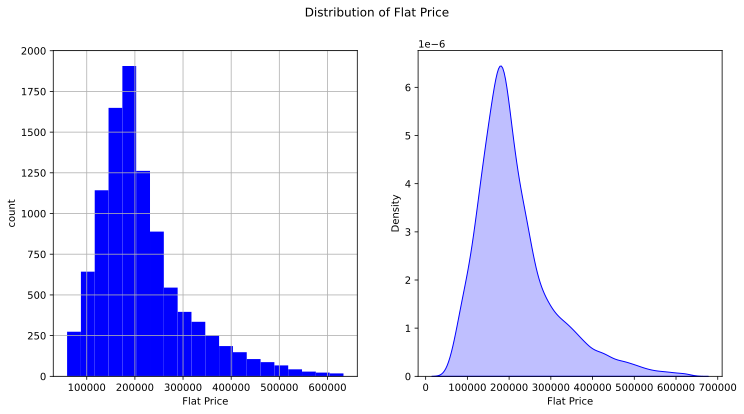

In [355]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
target.hist(density=False,color = '#0000FF', bins=20)
plt.ylabel('count')
plt.xlabel('Flat Price')

plt.subplot(1,2,2)
sns.kdeplot(target, color = '#0000FF', shade=True, legend=False)
plt.xlabel('Flat Price')

plt.suptitle('Distribution of Flat Price')
plt.show()

In [356]:
print("Skewness: %f" % target.skew())
print("Kurtosis: %f" % target.kurt())
print("Variance: %f" % variance(target))
print("Mode: %f" % mode(target)[0])
print("Median: %f" % median(target))

Skewness: 1.366877
Kurtosis: 2.249410
Variance: 8625262983.915672
Mode: 182938.078125
Median: 192269.648438


Распределние целевой переменной отклоняется от нормального, положительно ассиметрично, выборка смещена влево:
- коэфциентом асссиметрии больше 0 (1.36667)
- эксцесс 2.24 (распределение отклонено от нормального)
- mode = 182 938.9156
- mediana = 192 269.648438
- variance = 8 62262 983 (достаточно высокая дисперсия, следует проверить данные)

In [357]:
target_mean =target.mean()
target_moda = mode(target)[0]
target_mediana = median(target)

In [358]:
print("Mean: %f" % target_mean)
print("Mode: %f" % target_moda)
print("Median: %f" % target_mediana)

Mean: 214138.937500
Mode: 182938.078125
Median: 192269.648438


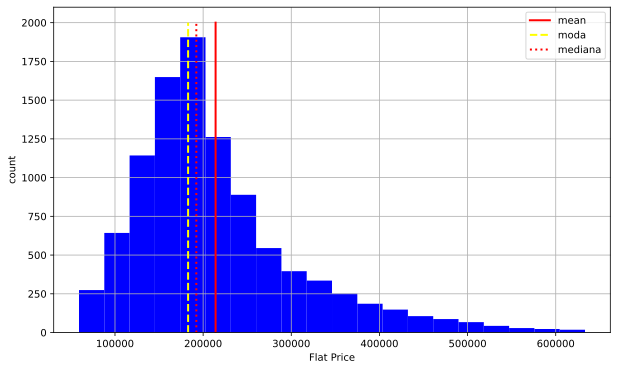

In [359]:
plt.figure(figsize = (10, 6))

y = np.linspace(0, 2000, 500) # Дял генерации вертикальной черты значений среднего,медианы и моды

target.hist(density = False, color = '#0000FF', bins=20)
plt.ylabel('count')
plt.xlabel('Flat Price')

plt.plot([target_mean]*500, y, color ='red', label='mean', linestyle='-', linewidth=2)
plt.plot([target_moda]*500, y, color ='yellow', label='moda', linestyle='--', linewidth=2)
plt.plot([target_mediana]*500, y, color ='red', label='mediana', linestyle=':', linewidth=2)

plt.legend()
plt.show()

In [360]:
print("50pr %f" % np.quantile(target, q=0.5))
print("25pr %f" % np.quantile(target, q=0.25))

50pr 192269.648438
25pr 153872.628906


In [361]:
np.quantile(target, q=0.25)

153872.62890625

Самая часто встречающаяся цена на квартиру в генеральной совокупности ниже среднего значения и приближается к медианному значению целефой переменной.

**Анализ степени зависимости целевой переменной от признаков** <a class ='anchor' id ='target_feature_corr'>

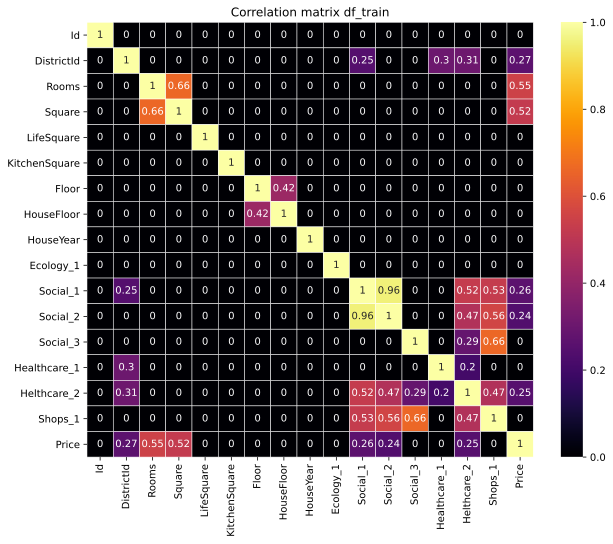

In [362]:
df_train_cor = df_train.corr()

plt.figure(figsize = (10,8))

np.round(df_train_cor, 2) # Округляем значение корреляции до 2 знаков после запятой

df_train_cor[np.abs(df_train_cor)<0.2] = 0 # Упрощаем отображение данных, по корреляции,оставив наиболеее полезные значения

sns.heatmap(df_train_cor, annot=True, linewidths=.5, cmap='inferno')

plt.title('Correlation matrix df_train')
plt.show()

In [363]:
df_train_cor['Price'] #Корреляции признаков с целевой переменной

Id               0.000000
DistrictId       0.265100
Rooms            0.550291
Square           0.520075
LifeSquare       0.000000
KitchenSquare    0.000000
Floor            0.000000
HouseFloor       0.000000
HouseYear        0.000000
Ecology_1        0.000000
Social_1         0.263286
Social_2         0.239226
Social_3         0.000000
Healthcare_1     0.000000
Helthcare_2      0.253090
Shops_1          0.000000
Price            1.000000
Name: Price, dtype: float64

Оценка корреляции целевой переменной Price показывает, что с ней наиболее тесно взаимосвязаны такие признаки, как:
- **Rooms** (кол-во комнат) ***0,55***
- **Square** (площадь квартиры) ***0.52***

Для рассмотрения степени связи целевой перемнной с исходными признаками, будем использовать так же те, чьи значения оказались ниже 50% (0.5), но при этом чуть выше чем установленная нами граница в 20%(0.2) :
- **Helthcare_2** (показатели местности по здравоохранению) ***0.25***
- **Social_1** (социальные показатели местности) ***0.26***
- **Social_2** (социальные показатели местности) ***0.24***

In [364]:
df_room = pd.concat([df_train['Price'],df_train['Rooms']], axis = 1)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.scatter(df_room['Rooms'],df_room['Price'])

plt.xlabel('Rooms')
plt.ylabel('Flat Price')

plt.subplot(1,2,2)
plt.scatter(df_train['Square'],df_train['Price'])
plt.xlabel('Square')
plt.ylabel('Flat Price')

plt.show()

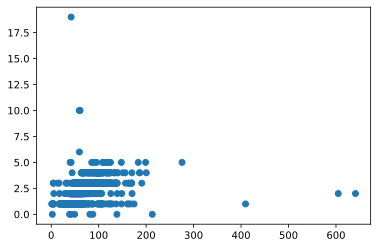

In [365]:
plt.scatter(df_train['Square'], df_train['Rooms'])


plt.show()

**Анализ признаков(features) целевой переменной** <a class ='anchor' id ='features_analytics'>

In [366]:
df_target_features_name = df_train.columns.drop(target.name) # имена исходных признаков (features name ) для целевой переменной

In [367]:
df_target_features = df_train.drop([target.name, 'Id'], axis = 1) # значения исходных признаков (features) для целевой переменной
df_target_features

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0             27    3.0  115.027313         NaN           10.0      4   
1             22    1.0   39.832523   23.169222            8.0      7   
2              1    3.0   78.342216   47.671970           10.0      2   
3              1    1.0   40.409908         NaN            1.0     10   
4             94    2.0   64.285065   38.562515            9.0     16   
...          ...    ...         ...         ...            ...    ...   
9995          61    2.0   49.090729   33.272625            6.0      3   
9996          27    2.0   64.307686   37.038422            9.0     13   
9997         178    1.0   29.648056   16.555363            5.0      3   
9998          21    1.0   32.330292   22.326870            5.0      3   
9999          94    1.0   35.815475   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
0           10.0       2014   0.075424         B         B        11   
1            8.0       1966   0.118537         B         B        30   
2           17.0       1988   0.025609         B         B        33   
3           22.0       1977   0.007122         B         B         1   
4           16.0       1972   0.282798         B         B        33   
...          ...        ...        ...       ...       ...       ...   
9995        12.0       1981   0.300323         B         B        52   
9996         0.0       1977   0.072158         B         B         2   
9997         5.0       1958   0.460556         B         B        20   
9998         9.0       1969   0.194489         B         B        47   
9999         9.0       1975   0.127376         B         B        43   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         3097         0           NaN            0        0       B  
1         6207         1        1183.0            1        0       B  
2         5261         0         240.0            3        1       B  
3          264         0           NaN            0        1       B  
4         8667         2           NaN            0        6       B  
...        ...       ...           ...          ...      ...     ...  
9995     10311         6           NaN            1        9       B  
9996       629         1           NaN            0        0       A  
9997      4386        14           NaN            1        5       B  
9998      8004         3         125.0            3        5       B  
9999      8429         3           NaN            3        9       B  

[10000 rows x 18 columns]

In [368]:
df_target_features.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

В признаках ***LifeSquare*** и ***Healthcare_1*** пропущены значения в кол-ве 2112 и 4798  соответственно.     

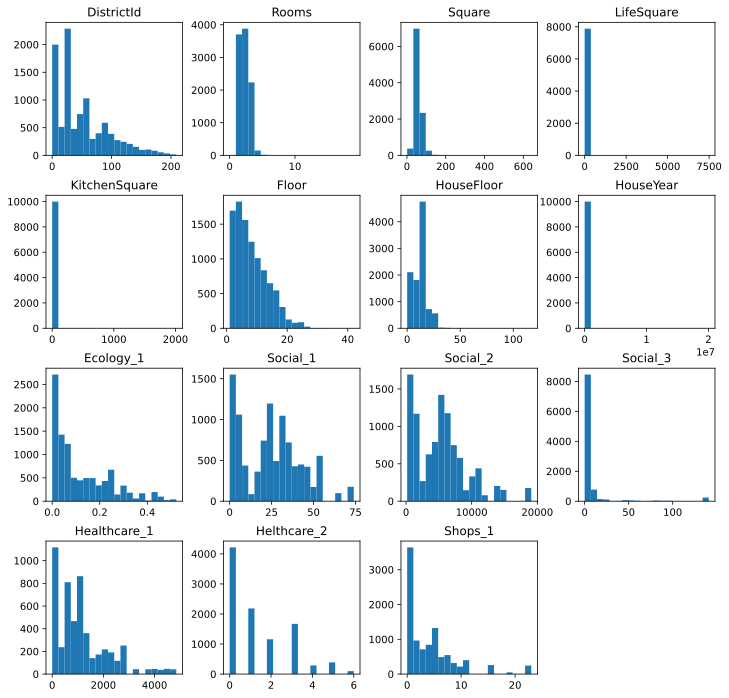

In [369]:
df_target_features.hist(figsize=(12,12), bins=20, grid=False)

plt.show()

<AxesSubplot:>

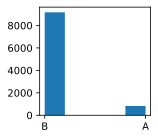

In [370]:
df_train['Shops_2'].hist(figsize=(2,2), bins=5, grid=False)

***Количественные признаки*** <a class ='anchor' id = 'num_features'>

In [371]:
df_target_features_num = df_train.select_dtypes(include=['float64', 'float32', 'float16']) # Кол-ные переменные
df_target_features_num.drop(target.name, axis = 1, inplace = True) 
df_target_features_num


C:\Users\aruda\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Rooms      Square  LifeSquare  KitchenSquare  HouseFloor  Ecology_1  \
0       3.0  115.027313         NaN           10.0        10.0   0.075424   
1       1.0   39.832523   23.169222            8.0         8.0   0.118537   
2       3.0   78.342216   47.671970           10.0        17.0   0.025609   
3       1.0   40.409908         NaN            1.0        22.0   0.007122   
4       2.0   64.285065   38.562515            9.0        16.0   0.282798   
...     ...         ...         ...            ...         ...        ...   
9995    2.0   49.090729   33.272625            6.0        12.0   0.300323   
9996    2.0   64.307686   37.038422            9.0         0.0   0.072158   
9997    1.0   29.648056   16.555363            5.0         5.0   0.460556   
9998    1.0   32.330292   22.326870            5.0         9.0   0.194489   
9999    1.0   35.815475   22.301367            6.0         9.0   0.127376   

      Healthcare_1  
0              NaN  
1           1183.0  
2            240.0  
3              NaN  
4              NaN  
...            ...  
9995           NaN  
9996           NaN  
9997           NaN  
9998         125.0  
9999           NaN  

[10000 rows x 7 columns]

In [372]:
print("Кол-во признаков целевой перемнной: %f" % len(df_target_features_name))
print("Кол-во КОЛИЧЕСТВЕННЫХ признаков целевой перемнной: %f" % len(df_target_features_num.columns))

Кол-во признаков целевой перемнной: 19.000000
Кол-во КОЛИЧЕСТВЕННЫХ признаков целевой перемнной: 7.000000


In [373]:
df_target_features_num.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

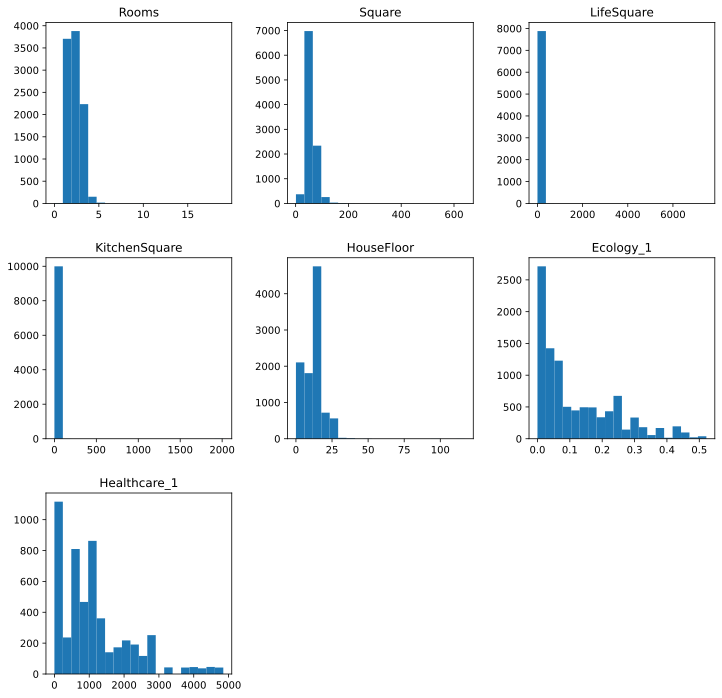

In [374]:
df_target_features_num.hist(figsize=(12,12), bins=20, grid=False)

plt.show()

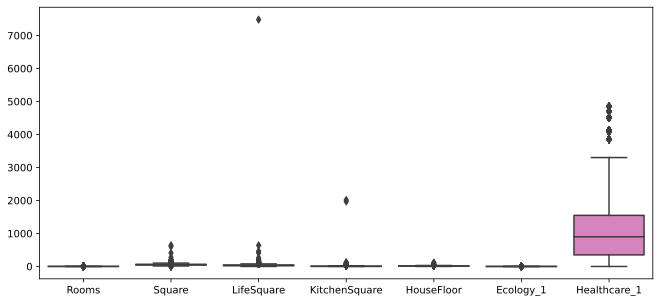

In [375]:
plt.figure(figsize=(11, 5))

sns.boxplot(data = df_target_features_num, whis=1.5)

plt.show()

Выбросы наблюдаются для признаков : ***Square, LifeSquare, KitchenSquare, Healthcare_1***

***Категориальные и бинарные признаки*** <a class ='anchor' id = 'cat_bin_features'>

In [376]:
df_target_features.drop(list(df_target_features_num.columns), axis =1 )
print(df_target_features.info())
df_target_features_cat = df_target_features.select_dtypes(include='category')
df_target_features_cat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

Ecology_2 Ecology_3 Shops_2
0            B         B       B
1            B         B       B
2            B         B       B
3            B         B       B
4            B         B       B
...        ...       ...     ...
9995         B         B       B
9996         B         B       A
9997         B         B       B
9998         B         B       B
9999         B         B       B

[10000 rows x 3 columns]

In [377]:
df_target_features_cat['Ecology_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [378]:
df_target_features_cat['Ecology_3'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [379]:
df_target_features_cat['Shops_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

Категориальные признаки ***Ecology_2, Ecology_3, Shops_2*** можно привести к бинарным.

In [380]:
df_target_features_bin = df_train.select_dtypes(include=['int64','int32','int16', 'int8'])

In [381]:
df_target_features_bin

Id  DistrictId  Floor  HouseYear  Social_1  Social_2  Social_3  \
0     11809          27      4       2014        11      3097         0   
1      3013          22      7       1966        30      6207         1   
2      8215           1      2       1988        33      5261         0   
3      2352           1     10       1977         1       264         0   
4     13866          94     16       1972        33      8667         2   
...     ...         ...    ...        ...       ...       ...       ...   
9995   1260          61      3       1981        52     10311         6   
9996  16265          27     13       1977         2       629         1   
9997   2795         178      3       1958        20      4386        14   
9998  14561          21      3       1969        47      8004         3   
9999   7202          94      9       1975        43      8429         3   

      Helthcare_2  Shops_1  
0               0        0  
1               1        0  
2               3        1  
3               0        1  
4               0        6  
...           ...      ...  
9995            1        9  
9996            0        0  
9997            1        5  
9998            3        5  
9999            3        9  

[10000 rows x 9 columns]

In [382]:
df_target_features_bin.columns.tolist()

['Id',
 'DistrictId',
 'Floor',
 'HouseYear',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1']

In [383]:
df_target_features_bin.sort_values(by= ['DistrictId'],ascending=True)['DistrictId'].unique() # кол-во районов

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [384]:
df_target_features_bin.sort_values(by= ['Social_3'],ascending=True)['Social_3'].unique() # колв-о категорий соц. состояния

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,
        16,  19,  20,  23,  24,  27,  37,  39,  45,  48,  56,  59,  73,
        84,  87,  93, 141], dtype=int16)

In [385]:
df_target_features_bin.describe()

Id    DistrictId         Floor     HouseYear      Social_1  \
count  10000.00000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean    8383.40770     50.400800      8.526700  3.990166e+03     24.687000   
std     4859.01902     43.587592      5.241148  2.005003e+05     17.532614   
min        0.00000      0.000000      1.000000  1.910000e+03      0.000000   
25%     4169.50000     20.000000      4.000000  1.974000e+03      6.000000   
50%     8394.50000     36.000000      7.000000  1.977000e+03     25.000000   
75%    12592.50000     75.000000     12.000000  2.001000e+03     36.000000   
max    16798.00000    209.000000     42.000000  2.005201e+07     74.000000   

           Social_2      Social_3   Helthcare_2       Shops_1  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean    5352.157400      8.039200      1.319500      4.231300  
std     4006.799803     23.831875      1.493601      4.806341  
min      168.000000      0.000000      0.000000      0.000000  
25%     1564.000000      0.000000      0.000000      1.000000  
50%     5285.000000      2.000000      1.000000      3.000000  
75%     7227.000000      5.000000      2.000000      6.000000  
max    19083.000000    141.000000      6.000000     23.000000

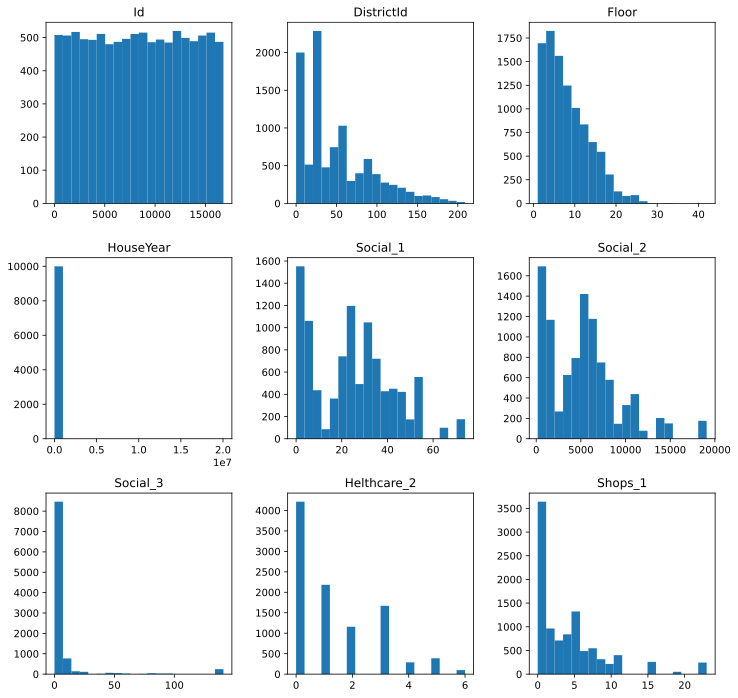

In [386]:
df_target_features_bin.hist(figsize=(12,12), bins=20, grid=False)

plt.show()

In [387]:
df_target_features_bin['Helthcare_2'].unique()

array([0, 1, 3, 2, 5, 4, 6], dtype=int8)

In [388]:
df_target_features_bin['Helthcare_2'].nunique()

7

In [389]:
df_target_features_bin['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

Признак ***Helthcare_2*** отнесем к категориальным со шкалой от 0 до 6.

**Выводы об основных статистиках для признаков**:


* **Rooms** - минимальное значение 0 (некорректные наблюдения)
* **Square** - минимальная площадь квартиры 1м2 (некорректные наблюдения)
* **LifeSquare** - максимальное значение жилой площади завышено 7480 м2 (некорректные наблюдения)
* **KitchenSquare** - максимальное значение площади кухни завышено 2014 м2 (некорректные наблюдения)
* **HouseFloor** - максимальное значение этажа дома 117 (некорректные наблюдения)
* **HouseYear** - данные необходимо проверить и отформатировать

* **LifeSquare,HouseYear** - имеют пропущенные данные
* **LifeSquare (std=86), Social_2 (std=4006), Healthcare_1 (std=1021)** -наблюдается очень высокое отклонение значений от среднего по выборке, существуют выбросы.

In [390]:
print('Max HouseYear: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].max()))
print('Min HouseYear: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].min()))
print('Median: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].median()))
print('variance HouseYear: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].var()))

Max HouseYear: 20052011
Min HouseYear: 1910
Median: 1977.0
variance HouseYear: 40200354832.38829


Значения признака **HouseYear** заполнены не корректно,т.к. максимальное значение 200520211, что похоже на два года 2005 и 2011, при минимально знаечнии 1971.

In [391]:
df_train.sort_values(by= ['Rooms'],ascending=True)['Rooms'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10., 19.], dtype=float32)

In [392]:
df_train.sort_values(by= ['HouseFloor'],ascending=True)['HouseFloor'].unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [393]:
df_train.sort_values(by= ['Floor'],ascending=True)['Floor'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

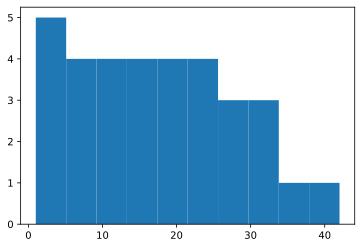

In [394]:
plt.hist(df_train.sort_values(by= ['Floor'],ascending=True)['Floor'].unique())
plt.show()

Дополнительные данные по уникальным значениям:
* Кол-во комнат имеет выброс равные 0 и 19,а так же под вопросом 10. Остальные значения 1-6 вполне логичные.
* Кол-во этажей дома так же имеет выбросы в виде значений равных 0, 99 и 117. Это доказывает и тот факт, что номер этажа квартиры находится в диапазоне от 1-42.

***Этажность дома и кол-во квартир можно использовать для генерации новых признаков позже.***

In [395]:
title_font = {
    'fontsize': 16,
    'fontweight': 10,
    'color': '#191970',
    'family':'Times New Roman'}

label_font = {
    'fontsize': 12,
    'fontweight': 8,
    'color': '#191970',
    'family':'Times New Roman'}

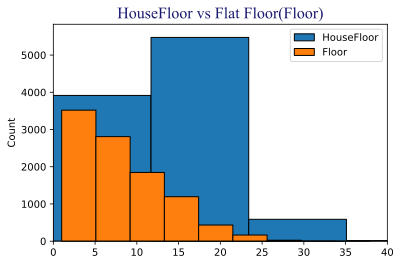

In [396]:
plt.figure(figsize=(6, 4))

plt.hist(df_train.sort_values(by= ['HouseFloor'],ascending=True)['HouseFloor'], label ='HouseFloor',ec ='black')
plt.ylabel('Count')
plt.title('HouseFloor vs Flat Floor(Floor)', fontdict = title_font)

plt.axis([0,40,0,df_train['HouseFloor'].value_counts().max()*2.5])

plt.hist(df_train.sort_values(by= ['Floor'],ascending=True)['Floor'], label ='Floor', ec ='black')

plt.legend()

(array([2514., 2765., 1775.,  696.,  976.,  520.,  360.,  204.,  139.,
          51.]),
 array([  0. ,  20.9,  41.8,  62.7,  83.6, 104.5, 125.4, 146.3, 167.2,
        188.1, 209. ]),
 <BarContainer object of 10 artists>)

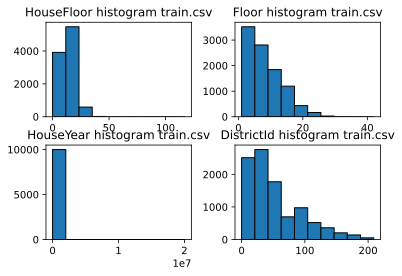

In [397]:
fig,ax = plt.subplots(nrows = 2, ncols = 2)

fig.subplots_adjust(hspace = 0.3, wspace = 0.3) # Вертикальные зазоры графика в дюймах
rc['figure.figsize'] = (8,6) #Установка размера фигуры 8' x 6'

ax1,ax2,ax3,ax4 = ax.flatten() # Преобразование в одномерный массив,чтобы не брать кортежи

x1 = df_train.sort_values(by= ['HouseFloor'],ascending=True)['HouseFloor']
x2 = df_train.sort_values(by= ['Floor'],ascending=True)['Floor']
x3 = df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear']                       
x4 = df_train.sort_values(by= ['DistrictId'],ascending=True)['DistrictId'] 

y = df_train.sort_values(by= ['Price'],ascending=True)
                               
ax1.hist(x1,ec ='black')


ax1.set_title('HouseFloor histogram train.csv')
ax2.set_title('Floor histogram train.csv')
ax3.set_title('HouseYear histogram train.csv')
ax4.set_title('DistrictId histogram train.csv')

ax2.hist(x2,ec ='black')
ax3.hist(x3,ec ='black')
ax4.hist(x4,ec ='black')

In [398]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [399]:
df_target_features_num['KitchenSquare'].nunique()

58

In [400]:
df_target_features_num['KitchenSquare'].value_counts().head(10)

1.0     2460
8.0     1306
5.0     1169
10.0    1075
6.0     1038
9.0      843
0.0      697
7.0      609
12.0     249
11.0     233
Name: KitchenSquare, dtype: int64

In [401]:
df_target_features_num.sort_values(by= ['KitchenSquare'],ascending=True)['KitchenSquare'].max()

2014.0

In [402]:
df_target_features_num.sort_values(by= ['KitchenSquare'],ascending=True)['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560946
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [403]:
df_target_features_num.sort_values(by= ['Square'],ascending=True)['Square'].describe()

count    10000.000000
mean        56.315681
std         21.058733
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

In [404]:
df_target_features_bin.sort_values(by= ['Social_2'],ascending=True)['Social_2'].describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

In [405]:
df_target_features_bin.sort_values(by= ['Social_2'],ascending=True)['Social_2'].mode()[0]

264

# Заключение по анализу данных (до обработки) <a class ='anchor' id = 'data_analysis_summary'>

***Количественные признаки:*** 
- Rooms (значение от 0 до 6,10 и 19) (минимальное значение 0 и,возможно, 19 - выбросы)
- Square (минимальная площадь квартиры 1 м2 - выбросы)
- LifeSquare (максимальное значение жилой площади завышено 7 480 м2 - выбросы)
- KitchenSquare (максимальное значение площади кухни завышено 2014 м2 - выбросы)
- HouseFloor (максимальное значение этажа дома 117, след. 99 - выбросы. Это доказывает и тот факт, что номер этажа квартиры находится в диапазоне от 1-42.)
- Ecology_1
- Healthcare_1

***Категориальные признаки:*** 
- Ecology_2 (значения A и B) - ***можно привести к бинарному***
- Ecology_3 (значения A и B) - ***можно привести к бинарному***
- Shops_2 (значения A и B)- ***можно привести к бинарному***

***Бинарные признаки:*** 
- DistrictId (кол-во уникальных номеров районов  - 205)
- Floor (значения от 1 до 42, без значения в 39)
- HouseYear (максимальное значение-200520211, что похоже на два года 2005 и 2021 или 2011, при минимальном значении 1971)  
- Social_1
- Social_2
- Social_3
- Helthcare_2 (можно теоретически отнести к категориальным со шкалой от 0 до 6).
- Shops_1

***Наиболее коррелирующие призаки с целевой переменной***
- **Rooms** (кол-во комнат) коэф-т корреляции ***0,55***
- **Square** (площадь квартиры) коэф-т корреляции ***0.52***
- **Helthcare_2** (показатели местности по здравоохранению 2)коэф-т корреляции ***0.25***
- **Social_1** (социальные показатели местности 1) коэф-т корреляции ***0.26***
- **Social_2** (социальные показатели местности 2)коэф-т корреляции ***0.24***


***Признаки с пустыми значениями(isna)*** - перед заполнением пустых значений **обработать выбросы!!**
- LifeSquare (2113 na)
- Helthcare_1 (4798 na)

***Признаки с наличием выборосов***
- Square (минимальная площадь квартиры 1 м2 - выбросы)* **(std=21.05)***
- Social_2 (moda = 264, mean = 5352, min =  168,  max =19083) ***(std=4006)***
- LifeSquare (имеет так же пустые значения na) ***(std=86)***
- KitchenSquare (мода = 1 м2, что является выбросом.) ***(std=86)***
- Healthcare_1( имеет так же пустые значения na) ***(std=1021)***


***Этажность дома и кол-во квартир можно использовать для генерации новых признаков позже.***


## Анализ и обработка данных (EDA) <a class='anchor' id='EDA'>

Используя выводы из анализа данных выше, в данном разделе будут решены следующие задачи:
* **Пропуски в исходных значениях** признаков в тренировочном датасете будут заполненны медианными значениями.
* **Строковые значения признаков** будут **переведены в бинарное значение** (числовое представление).    
* **Выбросы или неадекватные значения** в исходных значениях признаках,будут обработаны в соответствии логики.
* **Обработанный датасет** из train.csv  **будет разбит на обучающий и валидационный наборы данных**.

Для обработки дисходного датасета будет создан DataPiple для более удобной и быстрой обоработки исходных данных, а сам обработанный джатасет сохраним в файл pkl для повторного использования при выбоер оптимальной модели.


In [406]:
df_train.isna().sum() # Проверка на пропуски данных 0 - нет, 1 - есть, и подсчет кол-ва пропусков по признак

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [407]:
df_train['Square'].describe()

count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

In [408]:
print(df_train['Square'].median())
print(mode(df_train['Square']))

52.513309478759766
ModeResult(mode=array([37.49816], dtype=float32), count=array([2]))


In [409]:
df_train['LifeSquare'].describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [410]:
print(df_train['LifeSquare'].median())
print(mode(df_train['LifeSquare']))

32.7812614440918
ModeResult(mode=array([33.859653], dtype=float32), count=array([2]))


In [411]:
df_train.sort_values(by = ['LifeSquare'],ascending=True)['LifeSquare']

3113    0.370619
1829    0.641822
119     0.795539
9869    0.873147
6882    1.049867
          ...   
9975         NaN
9978         NaN
9981         NaN
9983         NaN
9991         NaN
Name: LifeSquare, Length: 10000, dtype: float32

In [412]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [413]:
df_train['KitchenSquare'].median()

6.0

In [414]:
df_train['Social_2'].median()

5285.0

In [415]:
df_train['Social_2'].describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

In [416]:
df_train['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [417]:
df_train['Healthcare_1'].median()

900.0

In [418]:
df_train.loc[df_train['Rooms'] == 0]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2194   3159          88    0.0   38.697117   19.345131            9.0      9   
3780   7317          27    0.0   41.790882         NaN            0.0     13   
5894    770          28    0.0   49.483501         NaN            0.0     16   
6401   9443          27    0.0   87.762619   85.125473            0.0      5   
7644   7917          27    0.0  212.932358  211.231125            0.0      2   
7929    456           6    0.0   81.491447         NaN            0.0      4   
9767  12638          27    0.0  138.427689  136.215500            0.0      4   
9869   3224          27    0.0    2.377248    0.873147            0.0      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2194        16.0       1982   0.127376         B         B        43   
3780         0.0       1977   0.211401         B         B         9   
5894         0.0       2015   0.118537         B         B        30   
6401        15.0       1977   0.211401         B         B         9   
7644         3.0       2008   0.211401         B         B         9   
7929         0.0       1977   0.243205         B         B         5   
9767         3.0       2016   0.075424         B         B        11   
9869         0.0       1977   0.017647         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
2194      8429         3           NaN            3        9       B   
3780      1892         0           NaN            0        1       B   
5894      6207         1        1183.0            1        0       B   
6401      1892         0           NaN            0        1       B   
7644      1892         0           NaN            0        1       B   
7929      1564         0         540.0            0        0       B   
9767      3097         0           NaN            0        0       B   
9869       469         0           NaN            0        0       B   

              Price  
2194  158998.109375  
3780   98129.976562  
5894  217009.343750  
6401  219281.921875  
7644  302211.250000  
7929  212864.796875  
9767  268394.750000  
9869  126596.945312

In [419]:
df_train['Rooms'].median()

2.0

In [420]:
df_train['Rooms'].median()

2.0

In [421]:
df_train.loc[df_train['Square'] < df_train['LifeSquare']] 
# Не соотносится с логикой и физикой (жидлая площадь меньше чем общая,а не наоборот)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
33      847          74    2.0  73.314972   74.131264            1.0      7   
64     3992           1    3.0  87.200623   87.730225            0.0     21   
77    11771          45    1.0  38.467278   39.624493            1.0     11   
100   13343          74    2.0  79.937668   82.931595            1.0      8   
111   13875          20    1.0  28.438793   32.514023            6.0      6   
...     ...         ...    ...        ...         ...            ...    ...   
9960  16258          48    3.0  96.056786   98.152802            1.0     15   
9962  14175          14    1.0  42.029175   44.682167           10.0      4   
9979   2201           6    1.0  40.043236   41.984322            1.0      3   
9987  11665           1    2.0  62.690056   64.602936           10.0     19   
9993   9289           1    3.0  84.486076   88.931511            0.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
33           6.0       1977   0.075779         B         B         6   
64          22.0       1977   0.007122         B         B         1   
77           9.0       1977   0.195781         B         B        23   
100         21.0       1977   0.075779         B         B         6   
111         10.0       2014   0.019509         B         B        37   
...          ...        ...        ...       ...       ...       ...   
9960         1.0       2017   0.041125         B         B        46   
9962         4.0       2018   0.238617         B         B        26   
9979        17.0       2014   0.243205         B         B         5   
9987        22.0       2018   0.007122         B         B         1   
9993        22.0       2016   0.007122         B         B         1   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
33        1437         3           NaN            0        2       B   
64         264         0           NaN            0        1       B   
77        5212         6           NaN            3        2       B   
100       1437         3           NaN            0        2       B   
111       7687        11         176.0            5        5       B   
...        ...       ...           ...          ...      ...     ...   
9960      9515         5           NaN            1       10       B   
9962      3889         6         705.0            3        6       B   
9979      1564         0         540.0            0        0       B   
9987       264         0           NaN            0        1       B   
9993       264         0           NaN            0        1       B   

              Price  
33    254005.375000  
64    300180.375000  
77    247440.531250  
100   226808.750000  
111   199248.109375  
...             ...  
9960  524365.562500  
9962   87556.382812  
9979  134888.078125  
9987  203908.187500  
9993  264213.562500  

[482 rows x 20 columns]

In [422]:
df_train.loc[df_train['Square'] < df_train['KitchenSquare']] 

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
2785   6569          27    1.0  38.220257   18.716856           84.0      4   
5273  13703          42    1.0  38.071693   19.723547           73.0      9   
6505  14679          81    1.0  32.276665   19.278395         1970.0      6   
9520  14656          62    1.0  47.100719   46.447960         2014.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2785        17.0       2018   0.011654         B         B         4   
5273        10.0       2006   0.158249         B         B        21   
6505         1.0       1977   0.006076         B         B        30   
9520         1.0       2014   0.072158         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
2785       915         0           NaN            0        0       B   
5273      5731         0           NaN            1        0       B   
6505      5285         0         645.0            6        6       B   
9520       629         1           NaN            0        0       A   

              Price  
2785   99079.960938  
5273  160488.031250  
6505  105539.554688  
9520  108337.484375

In [423]:
df_train.loc[df_train['HouseYear']>2019, 'HouseYear'] # Проверяем выбросы в годе строительства дома

1004        2020
1077        2020
1976        2020
2350        2020
3171        2020
3196        2020
5412        2020
5641        2020
6073        2020
7207        2020
7246        2020
7302        2020
7721        2020
7955        2020
8296        2020
8664        2020
8828        4968
9091        2020
9122        2020
9163    20052011
9400        2020
Name: HouseYear, dtype: int32

**Обработка исходного датасета без новых фичей и выбросов** <a class = 'anchor' id = 'initial_data_processing'>

In [424]:
#Разобьем исходный трейн датасет на тренировочный и тестовый
X = df_train.drop(['Price'], axis =1)
Y = df_train['Price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

x_train = X_train.copy()
x_test = X_test

In [425]:
x_train = X_train.copy()

In [426]:
# Выполним предобработку тренировочной части датасета на основании выводов анализа данных выше
# Заполним пропуски медианными значениями,а строковые значения переевдем в бинарные

class DataPipeline1:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
                
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        self.KitchenSquare_median = df['KitchenSquare'].median()
        self.LifeSquare_median =  df['LifeSquare'].median()
        self.Rooms_median =  df['Rooms'].median()
        self.Square_median =  df['Square'].median()
        self.HouseYear_median =  df['HouseYear'].median()             
        
                
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски заполняем медианами
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
             
        
        # 2. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'],prefix = 'Eco2')], axis = 1) 
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'],prefix = 'Eco3')], axis = 1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'],prefix = 'Shops2')], axis = 1) 
        
        df = df.drop(['Ecology_2','Ecology_3','Shops_2'], axis = 1) 
                
               
        # 3. Преобразование типов данных
        
        df['HouseFloor'] = df['HouseFloor'].astype('int32')
        df['Rooms'] = df['Rooms'].astype('int8')
        
        # 4. Отброс не нужного параметра ID
        df = df.drop('Id', axis =1)
        
        
        return df

In [427]:
pipe1 = DataPipeline1()
pipe1.fit(X_train)
X_train_prepeared = pipe1.transform(X_train)

C:\Users\aruda\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [428]:
X_train_prepeared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 7660 to 7270
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int16  
 1   Rooms          5000 non-null   int8   
 2   Square         5000 non-null   float32
 3   LifeSquare     5000 non-null   float32
 4   KitchenSquare  5000 non-null   float32
 5   Floor          5000 non-null   int8   
 6   HouseFloor     5000 non-null   int32  
 7   HouseYear      5000 non-null   int32  
 8   Ecology_1      5000 non-null   float32
 9   Social_1       5000 non-null   int8   
 10  Social_2       5000 non-null   int16  
 11  Social_3       5000 non-null   int16  
 12  Healthcare_1   5000 non-null   float32
 13  Helthcare_2    5000 non-null   int8   
 14  Shops_1        5000 non-null   int8   
 15  Eco2_A         5000 non-null   uint8  
 16  Eco2_B         5000 non-null   uint8  
 17  Eco3_A         5000 non-null   uint8  
 18  Eco3_

In [429]:
X_test = pipe1.transform(X_test)

In [430]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 6252 to 2764
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int16  
 1   Rooms          5000 non-null   int8   
 2   Square         5000 non-null   float32
 3   LifeSquare     5000 non-null   float32
 4   KitchenSquare  5000 non-null   float32
 5   Floor          5000 non-null   int8   
 6   HouseFloor     5000 non-null   int32  
 7   HouseYear      5000 non-null   int32  
 8   Ecology_1      5000 non-null   float32
 9   Social_1       5000 non-null   int8   
 10  Social_2       5000 non-null   int16  
 11  Social_3       5000 non-null   int16  
 12  Healthcare_1   5000 non-null   float32
 13  Helthcare_2    5000 non-null   int8   
 14  Shops_1        5000 non-null   int8   
 15  Eco2_A         5000 non-null   uint8  
 16  Eco2_B         5000 non-null   uint8  
 17  Eco3_A         5000 non-null   uint8  
 18  Eco3_

In [431]:
df1 = X_train_prepeared.copy()
df1['Price'] = pd.DataFrame({'Price':y_train})['Price']

**Сохранение подготовленного дата сета** используя обработку данных в ввиде ***заполнение пропусков в признаках медианным значениями*** и использования разбиение строковых значений ***на бинарные признаки SHOPS_2, ECOLOGY_2,ECOLOGY_3***

In [432]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 7660 to 7270
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int16  
 1   Rooms          5000 non-null   int8   
 2   Square         5000 non-null   float32
 3   LifeSquare     5000 non-null   float32
 4   KitchenSquare  5000 non-null   float32
 5   Floor          5000 non-null   int8   
 6   HouseFloor     5000 non-null   int32  
 7   HouseYear      5000 non-null   int32  
 8   Ecology_1      5000 non-null   float32
 9   Social_1       5000 non-null   int8   
 10  Social_2       5000 non-null   int16  
 11  Social_3       5000 non-null   int16  
 12  Healthcare_1   5000 non-null   float32
 13  Helthcare_2    5000 non-null   int8   
 14  Shops_1        5000 non-null   int8   
 15  Eco2_A         5000 non-null   uint8  
 16  Eco2_B         5000 non-null   uint8  
 17  Eco3_A         5000 non-null   uint8  
 18  Eco3_

In [433]:
df1.to_csv(PREPARED_DATASET_PATH, sep = ',', index=False, encoding='utf-8')

In [434]:
X_train_prepeared.describe()

DistrictId        Rooms       Square   LifeSquare  KitchenSquare  \
count  5000.000000  5000.000000  5000.000000  5000.000000    5000.000000   
mean     50.172400     1.893200    56.389702    35.250072       6.221600   
std      43.725899     0.810139    22.840694    18.859919      28.232946   
min       0.000000     0.000000     1.136859     0.641822       0.000000   
25%      18.750000     1.000000    41.750885    25.245647       1.000000   
50%      34.000000     2.000000    52.731188    32.613827       6.000000   
75%      75.000000     2.000000    65.813046    41.067337       9.000000   
max     208.000000     5.000000   641.065186   638.163208    1970.000000   

             Floor   HouseFloor     HouseYear    Ecology_1     Social_1  ...  \
count  5000.000000  5000.000000  5.000000e+03  5000.000000  5000.000000  ...   
mean      8.485200    12.533600  5.995540e+03     0.117473    24.436800  ...   
std       5.202422     6.729006  2.835502e+05     0.118304    17.601238  ...   
min       1.000000     0.000000  1.912000e+03     0.000000     0.000000  ...   
25%       4.000000     9.000000  1.974000e+03     0.017647     6.000000  ...   
50%       7.000000    12.000000  1.977000e+03     0.072158    25.000000  ...   
75%      12.000000    17.000000  2.001250e+03     0.194812    35.000000  ...   
max      42.000000   117.000000  2.005201e+07     0.521867    74.000000  ...   

          Social_3  Healthcare_1  Helthcare_2      Shops_1       Eco2_A  \
count  5000.000000   5000.000000  5000.000000  5000.000000  5000.000000   
mean      7.839200    981.398193     1.302400     4.151200     0.010600   
std      23.566952    754.115112     1.479795     4.755593     0.102419   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000    810.000000     0.000000     1.000000     0.000000   
50%       2.000000    830.000000     1.000000     3.000000     0.000000   
75%       4.000000    900.000000     2.000000     5.000000     0.000000   
max     141.000000   4849.000000     6.000000    23.000000     1.000000   

            Eco2_B       Eco3_A       Eco3_B     Shops2_A     Shops2_B  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean      0.989400     0.026600     0.973400     0.083400     0.916600  
std       0.102419     0.160927     0.160927     0.276514     0.276514  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       1.000000     0.000000     1.000000     0.000000     1.000000  
50%       1.000000     0.000000     1.000000     0.000000     1.000000  
75%       1.000000     0.000000     1.000000     0.000000     1.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 21 columns]

Требуется стандартизация признаков, из-за разности в значениях mean, std, что говорит о невозможности их сравнить по влиянию на целевую перемнную после прогноза и обучения на модели. Но для наглядности проведем обучение на не стандартизированных признаках и сравним результат.

#### Подбор предварительной модели для исходного датасета.  <a class ='anchor' id ='intial_train_model'>

В данном разделе произведены подборки простых и сложных моделей для исходного тренировочного датасета до генерации новых признаков, изменения данных для обучения в датасете и оббработкой пропусков не модами,а иными значениями.
Будут просчитаны ошибки R2 и сделаны выводы для простой и сложной моделей.

**Стандартизация признаков тренировочного набора X_train_prepeared:**

In [435]:
X_train_prepeared.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Eco2_A',
 'Eco2_B',
 'Eco3_A',
 'Eco3_B',
 'Shops2_A',
 'Shops2_B']

In [436]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_prepeared)
feature_names = X_train_prepeared.columns.tolist()
X_train_prepeared_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=feature_names)

In [437]:
X_train_prepeared_scaled

DistrictId     Rooms    Square  LifeSquare  KitchenSquare     Floor  \
0      -0.049687  1.366322  1.764067   -0.139797      -0.184966  2.021338   
1       1.597099  0.131842 -0.547459   -0.358375      -0.007850 -1.054461   
2      -0.987440  0.131842  0.502746    0.004543       0.204689  0.867913   
3      -0.530000  0.131842  0.319177    0.107417      -0.184966  0.098964   
4      -1.010312  0.131842  0.349817   -1.596391      -0.184966 -0.285511   
...          ...       ...       ...         ...            ...       ...   
4995   -0.644360  1.366322  1.018495   -0.139797      -0.184966  2.021338   
4996   -1.124673  1.366322  1.031773   -0.139797      -0.184966  0.675676   
4997   -0.895952 -1.102637 -0.730828   -0.513279       0.027573 -0.669986   
4998   -1.010312 -1.102637 -0.559416   -1.674711      -0.184966 -1.054461   
4999    0.270521  0.131842  0.489032    0.088427       0.346382  1.444626   

      HouseFloor  HouseYear  Ecology_1  Social_1  ...  Social_3  Healthcare_1  \
0      -1.714184  -0.014033  -0.645422  1.225218  ... -0.120486     -0.200785   
1      -0.525182  -0.014198   1.890218  0.145641  ...  1.704286      1.748732   
2       0.663820  -0.014043  -0.695969  0.997939  ... -0.205359      2.173117   
3       0.366569  -0.014174  -0.843892 -1.274856  ... -0.332669     -0.200785   
4       0.663820  -0.014174   1.062884 -1.104396  ... -0.332669     -0.585383   
...          ...        ...        ...       ...  ...       ...           ...   
4995    1.109695  -0.014174   0.008996  0.316100  ... -0.290232      0.267365   
4996    0.663820  -0.014174  -0.932864 -1.331676  ... -0.332669     -0.200785   
4997   -0.525182  -0.014156  -0.665978  0.202461  ... -0.290232      0.044563   
4998    0.663820  -0.014036   1.062884 -1.104396  ... -0.332669     -0.585383   
4999    0.663820  -0.014043  -0.383081 -1.274856  ... -0.290232     -0.200785   

      Helthcare_2   Shops_1    Eco2_A    Eco2_B    Eco3_A    Eco3_B  Shops2_A  \
0       -0.204373  1.230001 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
1        1.147301  1.440301 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
2       -0.880210 -0.242097 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
3       -0.880210 -0.872996 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
4       -0.880210 -0.872996 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
...           ...       ...       ...       ...       ...       ...       ...   
4995    -0.204373 -0.872996 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
4996    -0.880210 -0.662697 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
4997     0.471464  0.178502 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
4998    -0.880210 -0.872996 -0.103506  0.103506 -0.165308  0.165308 -0.301643   
4999    -0.880210 -0.872996 -0.103506  0.103506 -0.165308  0.165308  3.315178   

      Shops2_B  
0     0.301643  
1     0.301643  
2     0.301643  
3     0.301643  
4     0.301643  
...        ...  
4995  0.301643  
4996  0.301643  
4997  0.301643  
4998  0.301643  
4999 -3.315178  

[5000 rows x 21 columns]

In [438]:
X_train_prepeared_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   float64
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   float64
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   float64
 8   Ecology_1      5000 non-null   float64
 9   Social_1       5000 non-null   float64
 10  Social_2       5000 non-null   float64
 11  Social_3       5000 non-null   float64
 12  Healthcare_1   5000 non-null   float64
 13  Helthcare_2    5000 non-null   float64
 14  Shops_1        5000 non-null   float64
 15  Eco2_A         5000 non-null   float64
 16  Eco2_B         5000 non-null   float64
 17  Eco3_A         5000 non-null   float64
 18  Eco3_B  

**Простая модель(Линейная регрессия)** <a class ='anchor' id ='linear_initial'>

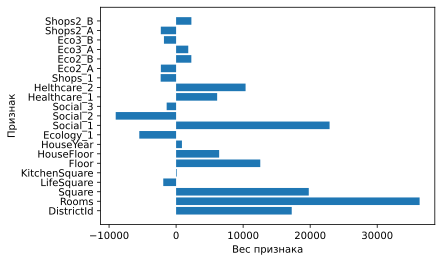

In [439]:
#Обучение  на стандартизованных признаках

lr_model = LinearRegression()

lr_model.fit(X_train_prepeared_scaled, y_train)

coef = lr_model.coef_

plt.rcParams['figure.figsize'] = (6, 4)
plt.barh(feature_names, coef.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [440]:
w0 = lr_model.intercept_ # w0

In [441]:
coef # коэффициенты линейной регрессии

array([17248.7527885 , 36325.03403842, 19790.78860534, -1915.26191605,
          99.39944222, 12556.44235443,  6422.09993366,   870.1276947 ,
       -5490.64363833, 22894.63291872, -9008.64836044, -1408.01953306,
        6123.98970394, 10363.85762945, -2304.09521742, -2272.75101056,
        2272.75101056,  1813.62817117, -1813.62817117, -2281.21814506,
        2281.21814506])

In [442]:
max(np.abs(coef)) # Слишком выоские веса -признак переобучения

36325.034038422156

In [443]:
# Метрики качества

def scores(y,y_pred,text,method):
    R2 = r2(y,y_pred)
    MSE = mse(y,y_pred)
    RMSE = np.sqrt(MSE)
    
    print(str(method) + "\t" + str(text) + "\n")
    print("R2 " + str(text)+ ":\t" + str(round(R2,3)))
    print("MSE " + str(text)+ ":\t" + str(round(MSE,3)))
    print("RMSE " + str(text)+ ":\t" + str(round(RMSE,3)) + "\n")
    

In [444]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   float64
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   float64
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   float64
 8   Ecology_1      5000 non-null   float64
 9   Social_1       5000 non-null   float64
 10  Social_2       5000 non-null   float64
 11  Social_3       5000 non-null   float64
 12  Healthcare_1   5000 non-null   float64
 13  Helthcare_2    5000 non-null   float64
 14  Shops_1        5000 non-null   float64
 15  Eco2_A         5000 non-null   float64
 16  Eco2_B         5000 non-null   float64
 17  Eco3_A         5000 non-null   float64
 18  Eco3_B  

In [445]:
# Прогноз на стандартизированных признаках

y_train_pred_lr = lr_model.predict(X_train_prepeared_scaled) # тренировочный прогноз
y_test_pred_lr = lr_model.predict(X_test) # тестовый прогноз

scores(y_train,y_train_pred_lr,"train","LinearRegression")
scores(y_test,y_test_pred_lr,"test","LinearRegression")

LinearRegression	train

R2 train:	0.481
MSE train:	4358977256.998
RMSE train:	66022.551

LinearRegression	test

R2 test:	0.49
MSE test:	4514882402.23
RMSE test:	67192.875



**Простая модель(линейная регрессия с L1-регуляризацией)** <a class ='anchor' id ='L1_initial'>

В качестве другой сложной модели была выбрана модель линейной регрессии с L1 -регуляризацией. 
В разделе будет проведено обучение модели на исходных тренировочных данных, а так же:
- Расчитана метрика R2 на двух наборах данных. 
- Сделаны итоговые выводы.
- Подобраны оптимальные гиперпараметры для модели. 

In [446]:
alp = 0.03
lasso_model = Lasso(alpha = alp)

In [447]:
lasso_model.fit(X_train_prepeared_scaled, y_train)
y_train_pred_lasso = lasso_model.predict(X_train_prepeared_scaled)
y_test_pred_lasso = lasso_model.predict(X_test)

scores(y_train,y_train_pred_lasso,"train", "Lasso LinearRegression")
scores(y_test,y_test_pred_lasso,"test", "Lasso LinearRegression")

Lasso LinearRegression	train

R2 train:	0.481
MSE train:	4358977257.06
RMSE train:	66022.551

Lasso LinearRegression	test

R2 test:	0.49
MSE test:	4514883383.23
RMSE test:	67192.882



**Сложная модель(Метод регрессии К-ближайших соседей (KNeighborsRegressor)** <a class ='anchor' id ='KN_Regressor'>

In [448]:
knr = KNeighborsRegressor(n_neighbors = 5,
                         weights = 'distance',
                         leaf_size = 30,
                         n_jobs = -1)

knr.fit(X_train_prepeared_scaled, y_train)

y_train_pred_knr = knr.predict(X_train_prepeared_scaled)
y_test_pred_knr = knr.predict(X_test)

scores(y_train,y_train_pred_knr,"train", "KNeighborsRegressor")
scores(y_test,y_test_pred_knr,"test", "KNeighborsRegressor")


KNeighborsRegressor	train

R2 train:	1.0
MSE train:	0.0
RMSE train:	0.0

KNeighborsRegressor	test

R2 test:	0.625
MSE test:	3316294236.486
RMSE test:	57587.275



In [449]:
knr = KNeighborsRegressor(n_neighbors = 5,
                         weights = 'uniform', # изменим с distance
                         leaf_size = 30,
                         n_jobs = -1)

knr.fit(X_train_prepeared_scaled, y_train)

y_train_pred_knr = knr.predict(X_train_prepeared_scaled)
y_test_pred_knr = knr.predict(X_test)

scores(y_train,y_train_pred_knr,"train", "KNeighborsRegressor")
scores(y_test,y_test_pred_knr,"test", "KNeighborsRegressor")

KNeighborsRegressor	train

R2 train:	0.759
MSE train:	2022959100.0
RMSE train:	44977.316

KNeighborsRegressor	test

R2 test:	0.619
MSE test:	3375699700.0
RMSE test:	58100.773



In [450]:
knr = KNeighborsRegressor(n_neighbors = 6, # изменим кол-во "соседей"
                         weights = 'distance',
                         leaf_size = 30,
                         n_jobs = -1)

knr.fit(X_train_prepeared_scaled, y_train)

y_train_pred_knr = knr.predict(X_train_prepeared_scaled)
y_test_pred_knr = knr.predict(X_test)

scores(y_train,y_train_pred_knr,"train", "KNeighborsRegressor")
scores(y_test,y_test_pred_knr,"test", "KNeighborsRegressor")

KNeighborsRegressor	train

R2 train:	1.0
MSE train:	0.0
RMSE train:	0.0

KNeighborsRegressor	test

R2 test:	0.626
MSE test:	3313881925.854
RMSE test:	57566.326



###### **Сложная модель(Метод случайный лес -регрессия (RandomForestRegressor)** <a class ='anchor' id ='initial_RandomForestRegressor'>

In [451]:
rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 10,
                                   min_samples_leaf = 1,
                                   random_state = 42)

rfreg_model.fit(X_train_prepeared_scaled,y_train)

y_train_pred_rfr = rfreg_model.predict(X_train_prepeared_scaled)
y_test_pred_rfr = rfreg_model.predict(X_test)

scores(y_train,y_train_pred_rfr,"train", "RandomForestRegressor")
scores(y_test,y_test_pred_rfr,"test", "RandomForestRegressor")

RandomForestRegressor	train

R2 train:	0.866
MSE train:	1123526479.55
RMSE train:	33519.047

RandomForestRegressor	test

R2 test:	0.633
MSE test:	3244441675.222
RMSE test:	56960.001



Подберем параметры модели, для улучшения точности прогноза на тестовых данных X_test из train.csv:

In [452]:
rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 117,
                                   min_samples_leaf = 2,
                                   random_state = 42)

rfreg_model.fit(X_train_prepeared_scaled,y_train)

y_train_pred_rfr = rfreg_model.predict(X_train_prepeared_scaled)
y_test_pred_rfr = rfreg_model.predict(X_test)

scores(y_train,y_train_pred_rfr,"train", "RandomForestRegressor")
scores(y_test,y_test_pred_rfr,"test", "RandomForestRegressor")

RandomForestRegressor	train

R2 train:	0.937
MSE train:	532510506.848
RMSE train:	23076.189

RandomForestRegressor	test

R2 test:	0.676
MSE test:	2869946992.637
RMSE test:	53571.886



 **Сложная модель(Метод регрессии градиентного бустинга (GradientBoostingRegressor)<a class='anchor' id ='GradientBoostingRegressor'>**

In [453]:
gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 7,
                                    min_samples_leaf = 2,
                                    random_state = 42)

gb_model.fit(X_train_prepeared_scaled,y_train)

y_train_pred_gb = gb_model.predict(X_train_prepeared_scaled)
y_test_pred_gb = gb_model.predict(X_test)

scores(y_train,y_train_pred_gb,"train", "GradientBoostingRegressor")
scores(y_test,y_test_pred_gb,"test", "GradientBoostingRegressor")

GradientBoostingRegressor	train

R2 train:	0.945
MSE train:	458290967.127
RMSE train:	21407.731

GradientBoostingRegressor	test

R2 test:	0.616
MSE test:	3395035312.3
RMSE test:	58266.932



### Подберем параметры для более точного прогноза:

In [454]:
gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 6,
                                    min_samples_leaf = 2,
                                    n_estimators = 30,
                                    random_state = 42)

gb_model.fit(X_train_prepeared_scaled,y_train)

y_train_pred_gb = gb_model.predict(X_train_prepeared_scaled)
y_test_pred_gb = gb_model.predict(X_test)

scores(y_train,y_train_pred_gb,"train", "GradientBoostingRegressor")
scores(y_test,y_test_pred_gb,"test", "GradientBoostingRegressor")

GradientBoostingRegressor	train

R2 train:	0.831
MSE train:	1417354017.519
RMSE train:	37647.762

GradientBoostingRegressor	test

R2 test:	0.667
MSE test:	2948687449.136
RMSE test:	54301.818



**Выводы по предварительным моделям: <a class = 'anchor' id = 'first_models_comments'>** 

Среди двух рассмотренных простых моделей  регрессии - линейная регрессия и регрессия с L1-регуляризацией - наиболее лучшее предсказание дает модель модель с регуляризацией,однако точность по оценке R2 увеличена не значительно от обычной линейной регрессии (лишь 6-й знак после запятой в ошибке R2).

Показатели точности на тестовых данных:
1. **LinearRegression:** R2 = 0.49
2. **L1 regression:**    R2 = 0.49

Лучшая точность простой ререссионной модели ***R2: 0.4920135***
Поэтому были рассмотрены более сложные модели.
Показатели точности на тестовых данных:
1. **KNeighborsRegressor:**        R2 = 0.626
2. **RandomForestRegressor:**      R2 = 0.676
3. **GradientBoostingRegressor:**  R2 = 0.667

Лучшие показатели точности сложных моделей регрессии ***R2: 0.676***

Как видно из моделей, используемых для тренировки на данных без обработки выбросов,генерации фитчей,а лишь используя стандартизацию признаков и заполнение пустых значений медианными значениями, наиболее точный алгоритм дает модель **GradientBoostingRegressor**. Однако модель RandomForestRegressor так же показала хороший результат и будет рассмотрена далее.

Далее проведем обработку исходных данных от выбросов, сгенерируем,при возможности, новый или новые признаки и обучим модель используя более успешный метод,а так же попробуем  бустинг и стекинг, перед выбором итоговой модели,которая будет использоваться на тестовых данных для предсказания.


## 3. Подбор модели предсказания целевой перемнной Price <a class ='anchor' id ='models_search'>


В данном разделе произведем  анализ более сложных моделей на даннхы из обработанного датасета, содержащего новый признак. Будет произведена оценка точности модели на основе метрики R2 и RMSE и произведен подбор гипперпараметров модели, перед ее проверкой на тестовом датасете из файла test.csv.

**Обработка исходного датасета c генерацией фичей и обработкой выбросов**

По обработке выбросов, указанных в выводах выше, было принято решение:
- **KitchenSquare**: выброс в 0 м2 кухни заполним медианным значением
- **Square**: выброс в 1м2 площади квартиры заполним медианным значением, так же те значения,которые меньше жилой площади,а так же и меньше площади кухни.
- **LifeSquare**: выброс в 0.37 или меньше 8 м2 (т.к cогласно действующим СНиПам, минимальная площадь комнаты должна быть не менее 8 квадратных метров (п. 5.3 СП 5.413330.2011) заполним медианным значением
- **Rooms** - выброс в значение 0 комнат, заменим на медианное значение.

- **Social_2** оставим без изменений,из-за невозможности определить методлику расчета значения признака.
- **Healthcare_1** -оставим без изменения, обработав только заполнение пустых значений медианой.
- **HouseYear** - надо убрать выбросы -20052011 и 4986 (те,что попадают в выборку >2021) заполним медианным значением.

По обработке категориальных признаков, указанных в выводах выше, было принято решение:
- **Ecology_2** (значения A и B) - приведем к бинарному значени 0 и 1
- **Ecology_3** (значения A и B) - приведем к бинарному значени 0 и 1
- **Shops_2** (значения A и B)- приведем к бинарному значени 0 и 1


Предлагается ввести новые признаки:
1. Доля жилой площади в общей площади квартиры (**LifeSquare_index**)

In [455]:
class DataPipeline_final:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
                
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        self.KitchenSquare_median = df['KitchenSquare'].median()
        self.LifeSquare_median =  df['LifeSquare'].median()
        self.Rooms_median =  df['Rooms'].median()
        self.Square_median =  df['Square'].median()
        self.HouseYear_median =  df['HouseYear'].median()             
        
                
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски заполняем медианами
        
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        
        # 2. Выбросы (outliers)
        
        df.loc[df['KitchenSquare'] == 0, 'KitchenSquare'] = self.KitchenSquare_median
        df.loc[df['LifeSquare'] < 8, 'LifeSquare'] = self.LifeSquare_median
        df.loc[df['Square'] <= df['LifeSquare'], 'Square'] = self.Square_median
        df.loc[df['Square'] <= df['KitchenSquare'], 'Square'] = self.Square_median
        df.loc[df['Square'] ==0, 'Square'] = self.Square_median
        df.loc[df['Rooms'] == 0, 'Rooms'] = self.Rooms_median
        df.loc[df['HouseYear'] >2021, 'HouseYear'] = self.HouseYear_median
        
        # 3. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'],prefix = 'Eco2')], axis = 1) 
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'],prefix = 'Eco3')], axis = 1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'],prefix = 'Shops2')], axis = 1) 
        
        df = df.drop(['Ecology_2','Ecology_3','Shops_2'], axis = 1) 
                
        
        # 4. Новые фичи (features)
        
        # Доля жилой площади в общей площади квартиры (LifeSquare_index)
        df['LifeSquare_index'] = df['Square']/df['LifeSquare']
        
        # 5. Преобразование типов данных
        
        df['HouseFloor'] = df['HouseFloor'].astype('int32')
        df['Rooms'] = df['Rooms'].astype('int8')
        
        # 6. Отброс не нужного параметра ID
        df = df.drop('Id', axis =1)
        
        
        return df

**Предобработанный исходный датасет с новыми фичами (df_prepeared_train):<a class='anchor' id='df_prepeared_train'>**

In [456]:
pipe_final = DataPipeline_final()
pipe_final.fit(x_train)
df = pipe_final.transform(x_train)

X_test = pipe_final.transform(x_test)

C:\Users\aruda\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\aruda\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\aruda\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 7660 to 7270
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        5000 non-null   int16  
 1   Rooms             5000 non-null   int8   
 2   Square            5000 non-null   float32
 3   LifeSquare        5000 non-null   float32
 4   KitchenSquare     5000 non-null   float32
 5   Floor             5000 non-null   int8   
 6   HouseFloor        5000 non-null   int32  
 7   HouseYear         5000 non-null   int32  
 8   Ecology_1         5000 non-null   float32
 9   Social_1          5000 non-null   int8   
 10  Social_2          5000 non-null   int16  
 11  Social_3          5000 non-null   int16  
 12  Healthcare_1      5000 non-null   float32
 13  Helthcare_2       5000 non-null   int8   
 14  Shops_1           5000 non-null   int8   
 15  Eco2_A            5000 non-null   uint8  
 16  Eco2_B            5000 non-null   uint8

In [458]:
df['Price'] = pd.DataFrame({'Price': y_train})['Price']
df

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
7660          48      3  96.678123   32.613827            1.0     19   
275          120      2  43.886520   28.491898            6.0      3   
2985           7      2  67.871544   35.335793           12.0     13   
5646          27      2  63.679115   37.275776            1.0      9   
5849           6      2  64.378891   32.613827            1.0      7   
...          ...    ...        ...         ...            ...    ...   
5734          22      3  79.650436   32.613827            1.0     19   
5191           1      3  79.953690   32.613827            1.0     12   
5390          11      1  39.698662   25.570715            7.0      5   
860            6      1  43.613430   32.613827            1.0      3   
7270          62      2  67.558342   36.917664           16.0     16   

      HouseFloor  HouseYear  Ecology_1  Social_1  ...  Helthcare_2  Shops_1  \
7660           1       2017   0.041125        46  ...            1       10   
275            9       1970   0.341072        27  ...            3       11   
2985          17       2014   0.035145        42  ...            0        3   
5646          15       1977   0.017647         2  ...            0        0   
5849          17       1977   0.243205         5  ...            0        0   
...          ...        ...        ...       ...  ...          ...      ...   
5734          20       1977   0.118537        30  ...            1        0   
5191          17       1977   0.007122         1  ...            0        1   
5390           9       1982   0.038693        28  ...            2        5   
860           17       2016   0.243205         5  ...            0        0   
7270          17       2014   0.072158         2  ...            0        0   

      Eco2_A  Eco2_B  Eco3_A  Eco3_B  Shops2_A  Shops2_B  LifeSquare_index  \
7660       0       1       0       1         0         1          2.964329   
275        0       1       0       1         0         1          1.540316   
2985       0       1       0       1         0         1          1.920759   
5646       0       1       0       1         0         1          1.708324   
5849       0       1       0       1         0         1          1.973975   
...      ...     ...     ...     ...       ...       ...               ...   
5734       0       1       0       1         0         1          2.442229   
5191       0       1       0       1         0         1          2.451527   
5390       0       1       0       1         0         1          1.552505   
860        0       1       0       1         0         1          1.337268   
7270       0       1       0       1         1         0          1.829973   

              Price  
7660  474638.812500  
275   294050.406250  
2985   89269.187500  
5646  178721.703125  
5849  168241.843750  
...             ...  
5734  216640.531250  
5191  241324.500000  
5390  163496.968750  
860   128710.468750  
7270  109129.984375  

[5000 rows x 23 columns]

In [459]:
df.to_csv(PREPARED_DATASET_PATH, sep = ',', index=False, encoding='utf-8')

In [460]:
df_prepeared_train = pd.read_csv(PREPARED_DATASET_PATH, sep =',')

df_prepeared_train = reduce_mem_usage(df_prepeared_train)

Memory usage of dataframe is 0.88 MB
Memory usage after optimization is: 0.23 MB
Decreased by 73.9%


In [461]:
df_prepeared_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        5000 non-null   int16  
 1   Rooms             5000 non-null   int8   
 2   Square            5000 non-null   float32
 3   LifeSquare        5000 non-null   float32
 4   KitchenSquare     5000 non-null   float32
 5   Floor             5000 non-null   int8   
 6   HouseFloor        5000 non-null   int8   
 7   HouseYear         5000 non-null   int16  
 8   Ecology_1         5000 non-null   float32
 9   Social_1          5000 non-null   int8   
 10  Social_2          5000 non-null   int16  
 11  Social_3          5000 non-null   int16  
 12  Healthcare_1      5000 non-null   float32
 13  Helthcare_2       5000 non-null   int8   
 14  Shops_1           5000 non-null   int8   
 15  Eco2_A            5000 non-null   int8   
 16  Eco2_B            5000 non-null   int8   


In [462]:
X_train_final = df_prepeared_train.drop(columns = 'Price', axis = 1)
X_train_final

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0             48      3  96.678123   32.613827            1.0     19   
1            120      2  43.886520   28.491898            6.0      3   
2              7      2  67.871544   35.335793           12.0     13   
3             27      2  63.679115   37.275776            1.0      9   
4              6      2  64.378891   32.613827            1.0      7   
...          ...    ...        ...         ...            ...    ...   
4995          22      3  79.650436   32.613827            1.0     19   
4996           1      3  79.953690   32.613827            1.0     12   
4997          11      1  39.698662   25.570715            7.0      5   
4998           6      1  43.613430   32.613827            1.0      3   
4999          62      2  67.558342   36.917664           16.0     16   

      HouseFloor  HouseYear  Ecology_1  Social_1  ...  Healthcare_1  \
0              1       2017   0.041125        46  ...         830.0   
1              9       1970   0.341072        27  ...        2300.0   
2             17       2014   0.035145        42  ...        2620.0   
3             15       1977   0.017647         2  ...         830.0   
4             17       1977   0.243205         5  ...         540.0   
...          ...        ...        ...       ...  ...           ...   
4995          20       1977   0.118537        30  ...        1183.0   
4996          17       1977   0.007122         1  ...         830.0   
4997           9       1982   0.038693        28  ...        1015.0   
4998          17       2016   0.243205         5  ...         540.0   
4999          17       2014   0.072158         2  ...         830.0   

      Helthcare_2  Shops_1  Eco2_A  Eco2_B  Eco3_A  Eco3_B  Shops2_A  \
0               1       10       0       1       0       1         0   
1               3       11       0       1       0       1         0   
2               0        3       0       1       0       1         0   
3               0        0       0       1       0       1         0   
4               0        0       0       1       0       1         0   
...           ...      ...     ...     ...     ...     ...       ...   
4995            1        0       0       1       0       1         0   
4996            0        1       0       1       0       1         0   
4997            2        5       0       1       0       1         0   
4998            0        0       0       1       0       1         0   
4999            0        0       0       1       0       1         1   

      Shops2_B  LifeSquare_index  
0            1          2.964329  
1            1          1.540316  
2            1          1.920759  
3            1          1.708324  
4            1          1.973975  
...        ...               ...  
4995         1          2.442229  
4996         1          2.451527  
4997         1          1.552505  
4998         1          1.337268  
4999         0          1.829973  

[5000 rows x 22 columns]

**Функция расчета точности предсказаний модели** <a class ='anchor' id ='def_evaluate_predict'>

In [463]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(6,6))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    # диагональ, где true_values = pred_values
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

**Регрессионная модель дерева решений (DecissionTreeRegressor) <a class='anchor' id ='prepeared_DecissionTreeRegressor'>**

In [464]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=10,  
                                 min_samples_leaf=1,
                                 random_state=42)
dt_model.fit(X_train_final, y_train)

y_train_preds = dt_model.predict(X_train_final)
y_test_preds = dt_model.predict(X_test)

scores(y_train,y_train_preds,"train", "DecisionTreeRegressor")
scores(y_test,y_test_preds,"test", "DecisionTreeRegressor")

DecisionTreeRegressor	train

R2 train:	0.827
MSE train:	1455092360.724
RMSE train:	38145.673

DecisionTreeRegressor	test

R2 test:	0.578
MSE test:	3737479511.497
RMSE test:	61134.929



Попробуем подобрать гипперпаметры пока без использования поиска по сетке, снизив переобучение на тренировочных данных

In [465]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=7,  
                                 min_samples_leaf=2,
                                 random_state=42)

dt_model.fit(X_train_final, y_train)

y_train_preds = dt_model.predict(X_train_final)
y_test_preds = dt_model.predict(X_test)

scores(y_train,y_train_preds,"train", "DecisionTreeRegressor")
scores(y_test,y_test_preds,"test", "DecisionTreeRegressor")

DecisionTreeRegressor	train

R2 train:	0.699
MSE train:	2522919090.144
RMSE train:	50228.668

DecisionTreeRegressor	test

R2 test:	0.601
MSE test:	3529299668.355
RMSE test:	59407.909



Получается, что изменненные гипперпараметры, дающие низкую точность предсказания на обучении, дают более точный результат на тестовых данных:
- max_depth = 7
- min_samples_leaf = 2
- R2 = 0.601

А при параметрах ранее:
- max_depth = 10
- min_samples_leaf = 1
- R2 = 0.578

**Регрессионная модель случайного дерева решений (RandomForestRegressor) <a class='anchor' id ='prepeared_RandomForestRegressor'>**

Модель случайного дерева решений относится к моделям бэггинга, т.е. когда ошибка отклонения всех алгоритмов используеемых на  рандомных выборках, усредняется. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

R2:	0.862
RMSE:	34007.482
MSE:	1156508849.495


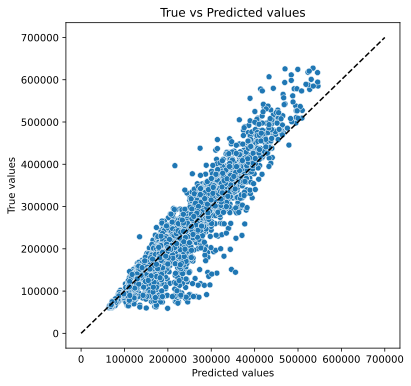

In [466]:
rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 10,
                                   min_samples_leaf = 1,
                                   random_state = 42)
rfreg_model.fit(X_train_final,y_train)
y_train_preds = rfreg_model.predict(X_train_final)
evaluate_preds(y_train, y_train_preds)

R2:	0.705
RMSE:	51091.169
MSE:	2610307547.882


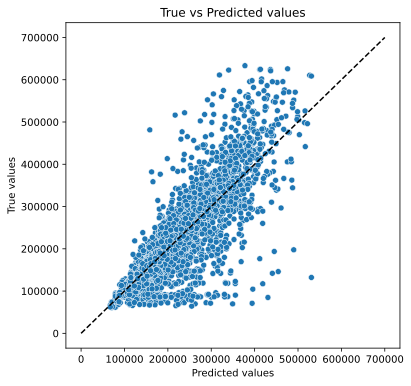

In [467]:
y_test_preds = rfreg_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Модель так же немного переобучена, поэтому возьмем те же гипперпараметры,что и в случае с моделью дерева решений:
- max_depth = 7
- min_samples_leaf = 2

R2:	0.756
RMSE:	45250.894
MSE:	2047643373.466


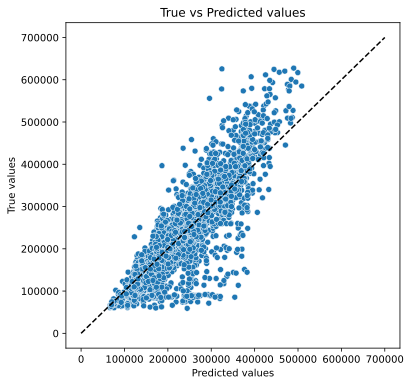

In [468]:
rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 7,
                                   min_samples_leaf = 2,
                                   random_state = 42)
rfreg_model.fit(X_train_final,y_train)
y_train_preds = rfreg_model.predict(X_train_final)
evaluate_preds(y_train, y_train_preds)

R2:	0.675
RMSE:	53606.267
MSE:	2873631842.955


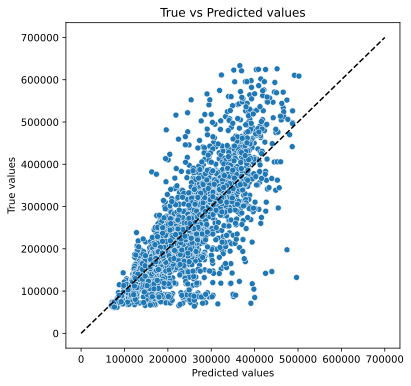

In [469]:
y_test_preds = rfreg_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Сравним данные Дерева решений и случайного леса на тестовых данных:
- max_depth = 7
- min_samples_leaf = 2
- R2_DT = 0.601
- R2_RFR = 0.675

А при изначальных параметрах:
- max_depth = 10
- min_samples_leaf = 1
- R2_DT = 0.578
- R2_RFR = 0.705

Необходимо выполнить более осознанный подбор параметров для регрессионной модели случайного леса, как дающей наиболее лучшее предсказание на тестовых данных.

In [470]:
rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 12,
                                   min_samples_leaf = 2,
                                   n_estimators = 300,
                                   random_state = 42)

rfreg_model.fit(X_train_final,y_train)
y_train_preds = rfreg_model.predict(X_train_final)
y_test_preds = rfreg_model.predict(X_test)

scores(y_train,y_train_preds,"train", "RandomForestRegressor")
scores(y_test,y_test_preds,"test", "RandomForestRegressor")

RandomForestRegressor	train

R2 train:	0.893
MSE train:	894982777.714
RMSE train:	29916.263

RandomForestRegressor	test

R2 test:	0.712
MSE test:	2545747329.271
RMSE test:	50455.399



In [471]:
rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 100,
                                   min_samples_leaf = 1,
                                   n_estimators = 150,
                                   random_state = 42)

rfreg_model.fit(X_train_final,y_train)
y_train_preds = rfreg_model.predict(X_train_final)
y_test_preds = rfreg_model.predict(X_test)

scores(y_train,y_train_preds,"train", "RandomForestRegressor")
scores(y_test,y_test_preds,"test", "RandomForestRegressor")

RandomForestRegressor	train

R2 train:	0.961
MSE train:	327333135.457
RMSE train:	18092.35

RandomForestRegressor	test

R2 test:	0.713
MSE test:	2537055644.038
RMSE test:	50369.193



**Регрессионная модель градиентного бустинга (GradientBoostingRegressor) <a class='anchor' id ='prepeared_GradientBoostingRegressor'>**

In [472]:
gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 10,
                                    min_samples_leaf = 1,
                                    random_state = 42)

gb_model.fit(X_train_final,y_train)

y_train_preds = gb_model.predict(X_train_final)
y_test_preds = gb_model.predict(X_test)

scores(y_train,y_train_preds,"train", "GradientBoostingRegressor")
scores(y_test,y_test_preds,"test", "GradientBoostingRegressor")

GradientBoostingRegressor	train

R2 train:	0.996
MSE train:	36531254.719
RMSE train:	6044.109

GradientBoostingRegressor	test

R2 test:	0.704
MSE test:	2618184936.036
RMSE test:	51168.202



In [473]:
gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 7,
                                    min_samples_leaf = 2,
                                    random_state = 42)

gb_model.fit(X_train_final,y_train)

y_train_preds = gb_model.predict(X_train_final)
y_test_preds = gb_model.predict(X_test)

scores(y_train,y_train_preds,"train", "GradientBoostingRegressor")
scores(y_test,y_test_preds,"test", "GradientBoostingRegressor")

GradientBoostingRegressor	train

R2 train:	0.949
MSE train:	428311858.773
RMSE train:	20695.697

GradientBoostingRegressor	test

R2 test:	0.722
MSE test:	2464614066.206
RMSE test:	49644.88



In [474]:
gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 6,
                                    min_samples_leaf = 6,
                                    n_estimators = 90,
                                    random_state = 42)

gb_model.fit(X_train_final,y_train)

y_train_preds = gb_model.predict(X_train_final)
y_test_preds = gb_model.predict(X_test)

scores(y_train,y_train_preds,"train", "GradientBoostingRegressor")
scores(y_test,y_test_preds,"test", "GradientBoostingRegressor")

GradientBoostingRegressor	train

R2 train:	0.891
MSE train:	915164682.256
RMSE train:	30251.689

GradientBoostingRegressor	test

R2 test:	0.72
MSE test:	2474004247.116
RMSE test:	49739.363



**Поиск гипперпараметров для выбранной модели GradientBosstingRegressor <a class='anchor' id ='GridSearch_GradientBosstingRegressor'>**

In [475]:
''' 
Для экономии времении загрузки закоментировал GridSearch (4 min 31 s)

%%time
params = {'max_depth': [4,5,6,7,8,15],
          'min_samples_leaf':[2,4,5,6,7,8,10],
          'n_estimators':[50,60,70,80,10,125]}

gs =GridSearchCV(gb_model, params,
                scoring = 'r2',
                cv = KFold(n_splits=5, random_state = 21, shuffle = True),
                n_jobs = -1
                )

gs.fit(X_train,y_train)

'''

" \nДля экономии времении загрузки закоментировал GridSearch (4 min 31 s)\n\n%%time\nparams = {'max_depth': [4,5,6,7,8,15],\n          'min_samples_leaf':[2,4,5,6,7,8,10],\n          'n_estimators':[50,60,70,80,10,125]}\n\ngs =GridSearchCV(gb_model, params,\n                scoring = 'r2',\n                cv = KFold(n_splits=5, random_state = 21, shuffle = True),\n                n_jobs = -1\n                )\n\ngs.fit(X_train,y_train)\n\n"

In [476]:
# gs.best_params_

best_params показали следующие данные: {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 125}

In [477]:
gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 6,
                                    min_samples_leaf = 5,
                                    n_estimators = 125,
                                    random_state = 42)

gb_model.fit(X_train_final,y_train)

y_train_preds = gb_model.predict(X_train_final)
y_test_preds = gb_model.predict(X_test)

scores(y_train,y_train_preds,"train", "GradientBoostingRegressor")
scores(y_test,y_test_preds,"test", "GradientBoostingRegressor")

GradientBoostingRegressor	train

R2 train:	0.918
MSE train:	690894580.032
RMSE train:	26284.874

GradientBoostingRegressor	test

R2 test:	0.724
MSE test:	2446764280.211
RMSE test:	49464.778



**Сложная модель  стекинга  StackingRegressor**<a class ='anchor' id = 'stacking'>

In [478]:
from sklearn.ensemble import StackingRegressor

alp = 0.03
lasso_model = Lasso(alpha = alp)

knr_model = KNeighborsRegressor(n_neighbors = 6,
                         weights = 'distance',
                         leaf_size = 30,
                         n_jobs = -1)

gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 6,
                                    min_samples_leaf = 5,
                                    n_estimators = 125,
                                    random_state = 42)

estimators = [('L1', lasso_model), ('knn',knr_model)]

stk = StackingRegressor(estimators=estimators,
                        final_estimator = gb_model,
                        n_jobs = -1)

stk.fit(X_train_final, y_train)
y_train_preds = stk.predict(X_train_final) 
y_test_preds = stk.predict(X_test) 

scores(y_train,y_train_preds,"train", "StackingRegressor")
scores(y_test,y_test_preds,"test", "GradientBoStackingRegressor")

StackingRegressor	train

R2 train:	0.909
MSE train:	764096806.877
RMSE train:	27642.301

GradientBoStackingRegressor	test

R2 test:	0.637
MSE test:	3211863382.047
RMSE test:	56673.304



Отличный от простого градиентного бустинга показала модель стекинга линейой модели, KNN и бустинга, как финальной. Попробуем добавить в estimators модель беггинга случайного лесса и сравнить результаты.

In [479]:
from sklearn.ensemble import BaggingRegressor

alp = 0.03
lasso_model = Lasso(alpha = alp)

knr_model = KNeighborsRegressor(n_neighbors = 6,
                         weights = 'distance',
                         leaf_size = 30,
                         n_jobs = -1)

gb_model = GradientBoostingRegressor(criterion ='mse',
                                    max_depth = 6,
                                    min_samples_leaf = 5,
                                    n_estimators = 125,
                                    random_state = 42)

rfreg_model = RandomForestRegressor(criterion ='mse',
                                   max_depth = 12,
                                   min_samples_leaf = 2,
                                   random_state = 42)


bg = BaggingRegressor(rfreg_model, base_estimator=125, n_jobs = -1)


estimators = [('L1', lasso_model), ('knn',knr_model), ('RF_bagging',bg)]

stk = StackingRegressor(estimators=estimators,
                        final_estimator = gb_model,
                        n_jobs = -1)

stk.fit(X_train_final, y_train)
y_train_preds = stk.predict(X_train_final) 
y_test_preds = stk.predict(X_test) 

scores(y_train,y_train_preds,"train", "Stacking_BaggingRegressor")
scores(y_test,y_test_preds,"test", "STacking_BaggingRegressor")

Stacking_BaggingRegressor	train

R2 train:	0.877
MSE train:	1031100489.59
RMSE train:	32110.753

STacking_BaggingRegressor	test

R2 test:	0.683
MSE test:	2801397803.61
RMSE test:	52928.233



Сохраним финальную модель в файл под названием final_model.pkl

In [480]:
final_model = stk
with open(MODEL_FILE_PATH,'wb') as file:
    pickle.dump(final_model, file)

## Предсказание целевой переменной Price на выбранной модели (test.csv)<a class ='anchor' id = 'final_model'>

In [481]:
df = pd.read_csv(TEST_DATASET_PATH, sep =',')
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [482]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

**Обработка данных**

In [483]:
pipe_final.fit(x_test)
df = pipe_final.transform(df)

**Проверка выбранной модели**

1. Модель: StackingRegressor
2. Параметры (estimators):
    - **Lasso**(alpha = 0.03)
    - **KNeighborsRegressor**(n_neighbors = 6, weights = 'distance',leaf_size = 30,n_jobs=-1)
    - **BaggingRegressor** (
        - **RandomForestRegressor**(criterion ='mse', max_depth = 12, min_samples_leaf = 2, random_state = 42),
        - **base_estimator**=125)

3. Точность предсказания на тренировочном датасете R2 = 0.861
4. Бизнес точность предсказания цены RMSE = 35828.452


In [484]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        5000 non-null   int16  
 1   Rooms             5000 non-null   int8   
 2   Square            5000 non-null   float32
 3   LifeSquare        5000 non-null   float32
 4   KitchenSquare     5000 non-null   float32
 5   Floor             5000 non-null   int8   
 6   HouseFloor        5000 non-null   int32  
 7   HouseYear         5000 non-null   int16  
 8   Ecology_1         5000 non-null   float32
 9   Social_1          5000 non-null   int8   
 10  Social_2          5000 non-null   int16  
 11  Social_3          5000 non-null   int16  
 12  Healthcare_1      5000 non-null   float32
 13  Helthcare_2       5000 non-null   int8   
 14  Shops_1           5000 non-null   int8   
 15  Eco2_A            5000 non-null   uint8  
 16  Eco2_B            5000 non-null   uint8  


In [485]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [486]:
predictions = stk.predict(df)
predictions

array([155447.95338408, 125571.30752823, 137679.77487971, ...,
       153898.05310409, 181945.08717495, 256169.24277339])

In [487]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  155447.953384
1  5925  125571.307528
2   960  137679.774880
3  3848  138494.259633
4   746  182486.611105

In [488]:
submit.to_csv('stk_submit.csv',sep =',', index=False)

In [489]:
submit.shape

(5000, 2)

In [490]:
df.shape

(5000, 22)

На Kaggle сохраненная модель показал точность 0.65654
Попробуем улчшить модель.

In [491]:
import xgboost as xgb

In [492]:
xgbr_model = xgb.XGBRegressor(base_score=0.5, 
                          booster='gbtree',
                          colsample_bylevel=1,
                          colsample_bynode=1,
                          colsample_bytree=1,
                          gamma=0,
                          importance_type='gain',
                          learning_rate=0.1,
                          max_delta_step=0,
                          max_depth=7,
                          min_child_weight=1,
                          missing=None,
                          n_estimators=125,
                          n_jobs=-1,
                          eval_metric = 'rmse',
                          nthread=None,
                          objective='reg:squarederror',
                          random_state=42,
                          reg_alpha=0.03,
                          reg_lambda=1,
                          scale_pos_weight=1,
                          seed=None,silent=None, subsample=1, verbosity=1)

In [493]:
xgbr_model.fit(X_train_final, y_train)
y_train_preds = xgbr_model.predict(X_train_final) 
y_test_preds = xgbr_model.predict(X_test) 

scores(y_train,y_train_preds,"train", "XGBRegressor")
scores(y_test,y_test_preds,"test", "XGBRegressor")

XGBRegressor	train

R2 train:	0.948
MSE train:	439403420.0
RMSE train:	20961.951

XGBRegressor	test

R2 test:	0.719
MSE test:	2491018200.0
RMSE test:	49910.1



In [495]:
final_model = xgbr_model
with open('./xgbbt_model_final.pkl','wb') as file:
    pickle.dump(final_model, file)

In [496]:
submit = pd.read_csv('./sample_submission.csv')
predictions = xgbr_model.predict(df)
submit['Price'] = predictions
submit.to_csv('xbr_submit.csv',sep =',', index=False)